# Fake News Detection

### Import statements

In [1]:
import numpy as np 
import pandas as pd 
import re
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Read the data
The data consists of fake and true files seperately. The two are combined into a single dataset and the target feature label is created: 0 for fake and 1 for real.

In [2]:
fake_data = pd.read_csv("Fake.csv")
fake_data["label"] = 0
real_data = pd.read_csv("True.csv")
real_data["label"] = 1

In [4]:
data = pd.concat([fake_data, real_data])
#data is shuffled to mix the label feature
data = shuffle(data, random_state = 2)
data.head()

,title,text,subject,date,label
15137,United Nations chief 'very worried' by Saudi-L...,UNITED NATIONS (Reuters) - U.N. Secretary-Gene...,worldnews,"November 10, 2017",1
18651,Police to remove people from Catalan voting st...,BARCELONA (Reuters) - Police will remove peopl...,worldnews,"September 30, 2017",1
1880,WATCH: Arnold Schwarzenegger Just BURNED Trum...,"Back in February, Donald Trump decided he was ...",News,"April 5, 2017",0
20256,OBAMA WARNS COPS TO RECOGNIZE BLACK LIVES MATT...,Watch Barack Obama identify himself as the lea...,left-news,"Jul 18, 2016",0
17886,Myanmar takes first step to ease Buddhist-Musl...,YANGON (Reuters) - Myanmar on Tuesday launched...,worldnews,"October 10, 2017",1


In [5]:
data.reset_index(level=0, inplace=True)

In [6]:
data.drop(["index"],axis = 1,inplace = True)

In [7]:
data.head()

,title,text,subject,date,label
0,United Nations chief 'very worried' by Saudi-L...,UNITED NATIONS (Reuters) - U.N. Secretary-Gene...,worldnews,"November 10, 2017",1
1,Police to remove people from Catalan voting st...,BARCELONA (Reuters) - Police will remove peopl...,worldnews,"September 30, 2017",1
2,WATCH: Arnold Schwarzenegger Just BURNED Trum...,"Back in February, Donald Trump decided he was ...",News,"April 5, 2017",0
3,OBAMA WARNS COPS TO RECOGNIZE BLACK LIVES MATT...,Watch Barack Obama identify himself as the lea...,left-news,"Jul 18, 2016",0
4,Myanmar takes first step to ease Buddhist-Musl...,YANGON (Reuters) - Myanmar on Tuesday launched...,worldnews,"October 10, 2017",1


### Check for missing values

In [8]:
data.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

### Text preprocessing

In [9]:
#stopwords from nltk library to be removed from the data
stopword = stopwords.words('english')

In [10]:
def text_processing(text):
    #remove punctuations
    text = re.sub("[^\w\d\s]+",' ',text)
    #lower case the words
    text = text.lower()
    #convert the sentences to tokens
    tok = nltk.word_tokenize(text)
    #remove stopwords
    words = [word for word in tok if word not in stopword]
    return words

In [11]:
#join the words into the data
def join_words(words):
    words = ' '.join(words)
    return words

In [12]:
#perform text processing on the data using the above defined functions
for i in data:
    if i == "label":
        continue
    else:
        data[i] = data[i].apply(lambda x: text_processing(x))

In [13]:
for j in data:
    if j == "label":
        continue
    else:
        data[j] = data[j].apply(lambda x: join_words(x))

In [14]:
data.head()

,title,text,subject,date,label
0,united nations chief worried saudi lebanon ten...,united nations reuters u n secretary general a...,worldnews,november 10 2017,1
1,police remove people catalan voting stations s...,barcelona reuters police remove people catalan...,worldnews,september 30 2017,1
2,watch arnold schwarzenegger burned trump appre...,back february donald trump decided going use w...,news,april 5 2017,0
3,obama warns cops recognize black lives matter ...,watch barack obama identify leader black lives...,left news,jul 18 2016,0
4,myanmar takes first step ease buddhist muslim ...,yangon reuters myanmar tuesday launched first ...,worldnews,october 10 2017,1


## Data exploration
reference: #https://www.kaggle.com/benfraser/visually-exploring-and-predicting-fake-news

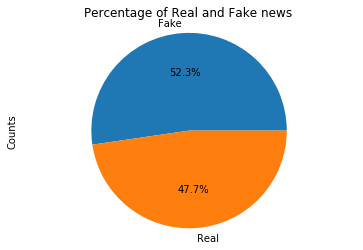

In [15]:
#Plot the percentage of fake and real news in the data
real = len(data[data["label"] == 1])
fake = len(data[data["label"] == 0])

df_count_pie = pd.DataFrame({'Class' : ['Real', 'Fake'], 
                             'Counts' : [real, fake]})
df_count_pie.Counts.groupby(df_count_pie.Class).sum().plot(kind='pie',autopct = '%1.1f%%')
plt.axis('equal')
plt.title("Percentage of Real and Fake news")
plt.show()

Text(0.5, 1.0, 'Subject wise total real and fake news')

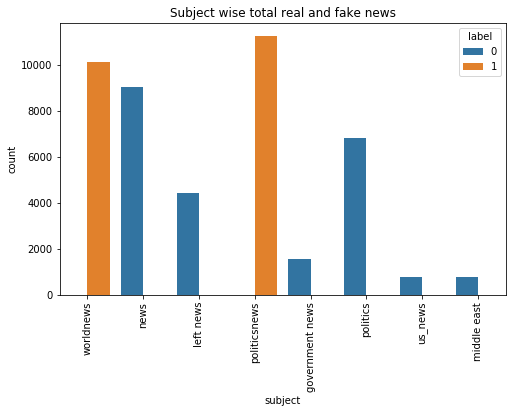

In [16]:
#Visualize the count of fake and real news based on Subject topics
plt.figure(figsize=(8,5))
ax = sns.countplot(x = "subject", hue = "label", data = data)
plt.xticks(rotation=90)
plt.title("Subject wise total real and fake news")

In [17]:
#create a corpus of words
def create_corpus(text_data):
    corpus = []
    for sentence in text_data:
        for word in sentence.split():
            corpus.append(word)
    return corpus

#pick the top words
def top_words(text_corpus, top_n=25, return_dict=False):
    def_dict = defaultdict(int)
    for word in text_corpus:
        def_dict[word] += 1
    most_common = sorted(def_dict.items(), key=lambda x : x[1], reverse=True)[:top_n]
    if return_dict:
        return most_common, def_dict
    else:    
        return most_common

#plot the words
def plot_words(word_list, word_counts, n, text_description, figsize=(15,5)):
    plt.figure(figsize=figsize)
    plt.xticks(rotation=90)
    plt.bar(word_list, word_counts)
    plt.title(f"Top {n} words in {text_description}", weight='bold')
    plt.ylabel("Word Count", weight='bold')
    plt.show()

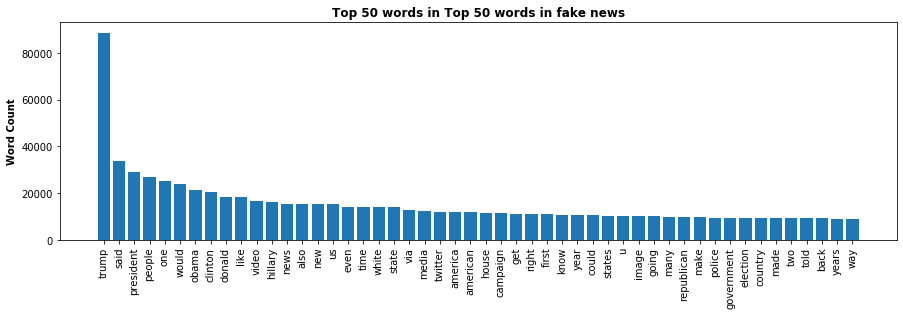

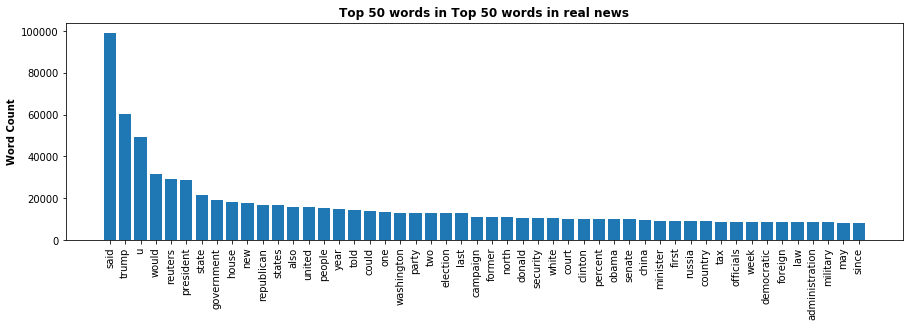

In [18]:
#plot the top 50 words count in the fake and real news
top_n = 50
data["news"] = data["title"] + " " + data["text"]
text_field = "news"

fake_news = data.loc[data['label'] == 0]
true_news = data.loc[data['label'] == 1]

fake_corpus = create_corpus(fake_news[text_field].values)
fake_top_n_words, fake_symptom_dict = top_words(fake_corpus, top_n = top_n, return_dict = True)
fake_words, fake_word_counts = zip(*fake_top_n_words)
plot_words(fake_words, fake_word_counts, 50, "Top 50 words in fake news", figsize=(15,4))

true_corpus = create_corpus(true_news[text_field].values)
true_top_n_words, true_symptom_dict = top_words(true_corpus, top_n=top_n, return_dict=True)
true_words, true_word_counts = zip(*true_top_n_words)
plot_words(true_words, true_word_counts, 50, "Top 50 words in real news", figsize=(15,4))

## Preparing data for models

In [19]:
#Prepare the data using title
X_title = data.title
y_title = data.label

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_title,y_title, test_size = 0.33, random_state = 42)

In [21]:
#use TF=IDF to convert the words to vectors
tvec = TfidfVectorizer(min_df = 2, max_df = 0.90, max_features = 1000)
word_vec = tvec.fit(X_train)

In [22]:
#convert the transform to dataframe
train_df = pd.DataFrame(tvec.transform(X_train).todense(),columns = tvec.get_feature_names())

In [23]:
train_df.head()

,000,10,100,11,12,13,15,20,2016,2018,...,wrong,xi,year,years,yemen,yet,york,young,yr,zimbabwe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
test_df = pd.DataFrame(tvec.transform(X_test).todense(),columns = tvec.get_feature_names())

In [25]:
test_df.head()

,000,10,100,11,12,13,15,20,2016,2018,...,wrong,xi,year,years,yemen,yet,york,young,yr,zimbabwe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
#Prepare the data using text
X_text = data.text
y_text = data.label

In [27]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_text,y_text, test_size = 0.33, random_state = 42)

In [28]:
tvec = TfidfVectorizer(min_df = 2, max_df = 0.90, max_features = 4000)
tvec.fit(X_train1)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.9, max_features=4000,
                min_df=2, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [29]:
#convert the transform to dataframe
train_df1 = pd.DataFrame(tvec.transform(X_train1).todense(),columns = tvec.get_feature_names())

In [30]:
test_df1 = pd.DataFrame(tvec.transform(X_test1).todense(),columns = tvec.get_feature_names())

In [31]:
#concatanate the text and title df
train = pd.concat([train_df,train_df1],axis = 1)
test = pd.concat([test_df,test_df1],axis = 1)

In [32]:
train.head()

,000,10,100,11,12,13,15,20,2016,2018,...,younger,youth,youtube,zealand,zero,zika,zimbabwe,zone,zones,zuma
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
test.head()

,000,10,100,11,12,13,15,20,2016,2018,...,younger,youth,youtube,zealand,zero,zika,zimbabwe,zone,zones,zuma
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
from sklearn.feature_selection.univariate_selection import SelectKBest, chi2, f_classif
fselect = SelectKBest(chi2 , k = 1000)
train_features = fselect.fit_transform(train, y_train1)
test_features = fselect.transform(test)

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.univariate_selection module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [35]:
#remove duplicate features
train = train.loc[:,~train.columns.duplicated()]

In [36]:
test = test.loc[:,~test.columns.duplicated()]

## Logistic Regression

In [37]:
def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [38]:
clf = LogisticRegression(C = 0.0015,random_state = 0,solver='liblinear', penalty='l2')
clf.fit(train,y_train1)

LogisticRegression(C=0.0015, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [105]:
#predict for test values
lr_pred = clf.predict(test)

In [106]:
print(lr_pred)

[0 0 0 ... 0 1 1]


In [107]:
#accuracy score
accuracy_score(lr_pred,y_test)
print("The accuracy of the Logistic Regression Model is", round(accuracy_score(lr_pred, y_test)*100,2))

The accuracy of the Logistic Regression Model is 83.23


In [101]:
y_test.value_counts()

0    7711
1    7106
Name: label, dtype: int64

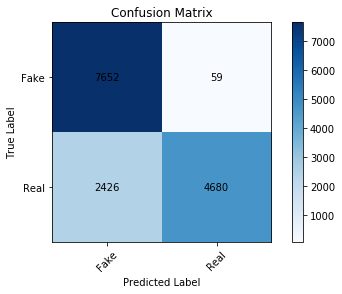

In [108]:
#confusion matrix
lr_res = confusion_matrix(y_test, lr_pred)
plot_confusion_matrix(lr_res, ['Fake','Real'])

In [103]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, lr_pred)

array([[7652,   59],
       [2426, 4680]])

In [104]:
from sklearn.metrics import classification_report
print(classification_report(y_test, lr_pred, target_names=["Fake", "Real"]))

              precision    recall  f1-score   support

        Fake       0.76      0.99      0.86      7711
        Real       0.99      0.66      0.79      7106

    accuracy                           0.83     14817
   macro avg       0.87      0.83      0.83     14817
weighted avg       0.87      0.83      0.83     14817



## XGBoost Classifier

In [87]:
xgb_model = XGBClassifier(learning_rate = 0.01, gamma = 1, n_estimators = 200)


In [88]:
eval_set = [(train,y_train), (test, y_test)]
xgb_model.fit(train,y_train, eval_metric = ["error"], eval_set = eval_set)

[0]	validation_0-error:0.134869	validation_1-error:0.131808
[1]	validation_0-error:0.134869	validation_1-error:0.131808
[2]	validation_0-error:0.134869	validation_1-error:0.131808
[3]	validation_0-error:0.134869	validation_1-error:0.131808
[4]	validation_0-error:0.134869	validation_1-error:0.131808
[5]	validation_0-error:0.135202	validation_1-error:0.131943
[6]	validation_0-error:0.135202	validation_1-error:0.131943
[7]	validation_0-error:0.135202	validation_1-error:0.131943
[8]	validation_0-error:0.135202	validation_1-error:0.131943
[9]	validation_0-error:0.135202	validation_1-error:0.131943
[10]	validation_0-error:0.135202	validation_1-error:0.131943
[11]	validation_0-error:0.135202	validation_1-error:0.131943
[12]	validation_0-error:0.135202	validation_1-error:0.131943
[13]	validation_0-error:0.135202	validation_1-error:0.131943
[14]	validation_0-error:0.135202	validation_1-error:0.131943
[15]	validation_0-error:0.135202	validation_1-error:0.131943
[16]	validation_0-error:0.135202	v

[135]	validation_0-error:0.109006	validation_1-error:0.106297
[136]	validation_0-error:0.109006	validation_1-error:0.106297
[137]	validation_0-error:0.096074	validation_1-error:0.094081
[138]	validation_0-error:0.109006	validation_1-error:0.106297
[139]	validation_0-error:0.108574	validation_1-error:0.105824
[140]	validation_0-error:0.095642	validation_1-error:0.093609
[141]	validation_0-error:0.108574	validation_1-error:0.105757
[142]	validation_0-error:0.108574	validation_1-error:0.105622
[143]	validation_0-error:0.107942	validation_1-error:0.104947
[144]	validation_0-error:0.095642	validation_1-error:0.093406
[145]	validation_0-error:0.107942	validation_1-error:0.104947
[146]	validation_0-error:0.095642	validation_1-error:0.093406
[147]	validation_0-error:0.095642	validation_1-error:0.093406
[148]	validation_0-error:0.095642	validation_1-error:0.093406
[149]	validation_0-error:0.095642	validation_1-error:0.093406
[150]	validation_0-error:0.095642	validation_1-error:0.093406
[151]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=1, learning_rate=0.01, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [95]:
xgb_pred = xgb_model.predict(test)
print(xgb_pred)

[0 1 0 ... 1 1 1]


In [109]:
accuracy_score(xgb_pred,y_test)
print("The accuracy of the XGBoost Model is", round(accuracy_score(xgb_pred, y_test)*100,2))

The accuracy of the XGBoost Model is 91.5


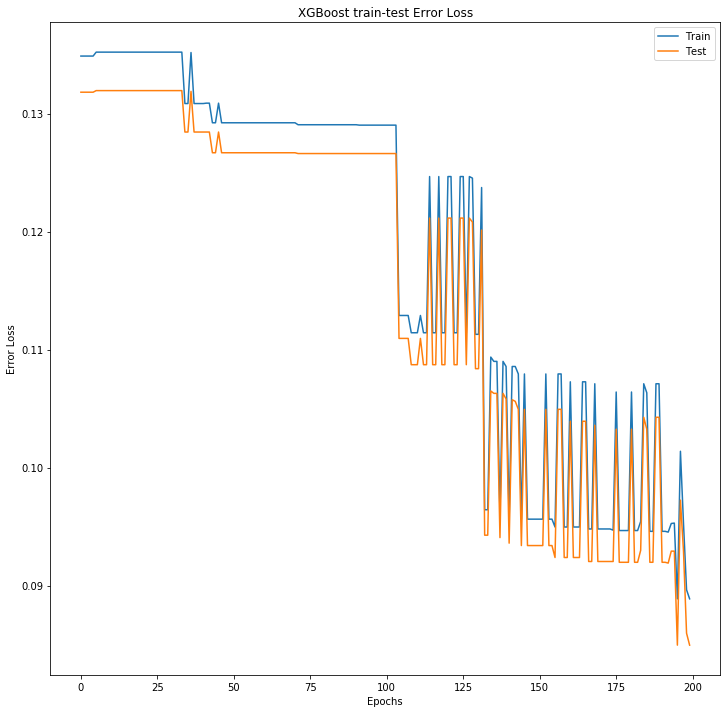

In [91]:
results = xgb_model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots(figsize = (12,12))
ax.plot(x_axis, results['validation_0']['error'], label = 'Train')
ax.plot(x_axis, results['validation_1']['error'], label = 'Test')
ax.legend()
plt.ylabel('Error Loss')
plt.xlabel('Epochs')
plt.title('XGBoost train-test Error Loss')
plt.show()

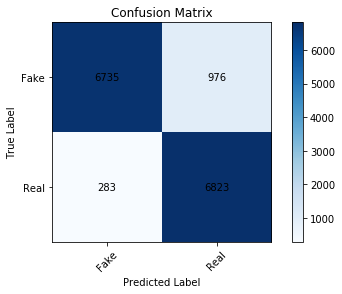

In [97]:
xg_res = confusion_matrix(y_test, xgb_pred)
plot_confusion_matrix(xg_res, ['Fake','Real'])

In [98]:
y_test.value_counts()

0    7711
1    7106
Name: label, dtype: int64

In [99]:
from sklearn.metrics import classification_report
print(classification_report(y_test, xgb_pred, target_names=["Fake", "Real"]))

              precision    recall  f1-score   support

        Fake       0.96      0.87      0.91      7711
        Real       0.87      0.96      0.92      7106

    accuracy                           0.92     14817
   macro avg       0.92      0.92      0.92     14817
weighted avg       0.92      0.92      0.92     14817



## CNN
CNN model is built on the text and title feature. 

In [71]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
import keras

X_news = data["title"] + " " + data["text"]
y_news = data["label"]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_news,y_news, test_size = 0.33, random_state = 42)

#tokenize the text data
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(X_train2)

X_train_cnn = tokenizer.texts_to_sequences(X_train2)
X_test_cnn = tokenizer.texts_to_sequences(X_test2)

#create a vocabulary size based on the word index created using tokenizer
vocab_size = len(tokenizer.word_index) + 1 

In [72]:
vocab_size

103332

In [73]:
#max length takes only sentences less than 50
maxlen = 50

#Pad the sentences in X_train_cnn and X_test_cnn so that all data values are of same length
X_train_cnn = pad_sequences(X_train_cnn, padding = 'post', maxlen = maxlen)
X_test_cnn = pad_sequences(X_test_cnn, padding = 'post', maxlen = maxlen)

In [74]:
#embedding dimension is set to 50
embedding_dim = 50
#define the optimizer with lr = 0.02
opt = keras.optimizers.Adam(learning_rate = 0.01)

#define the model layers with their filters, kernels, loss is set to binary_
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer = opt,
              loss='mse',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 50)            5166600   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 48, 128)           19328     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 24, 128)           0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 24, 128)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 20, 128)           82048     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 10, 128)          

In [78]:
#train the model for 10 epochs, batch size of 32
model_train = model.fit(X_train_cnn, y_train2,
                    epochs = 10,
                    verbose = False,
                    validation_data=(X_test_cnn, y_test2),
                    batch_size = 64)

In [110]:
#model.save("model.h5")
from keras.models import load_model
model1 = load_model("model.h5")
model1.summary()


/Users/admin/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 50)            5171250   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 48, 128)           19328     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 24, 128)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 24, 128)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 20, 128)           82048     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 10, 128)          

In [111]:
loss, accuracy = model1.evaluate(X_test_cnn, y_test2, verbose = True)
print("Testing Accuracy:  {:.4f}".format(accuracy))

14817/14817 [==============================] - 5s 350us/step
Testing Accuracy:  0.6698


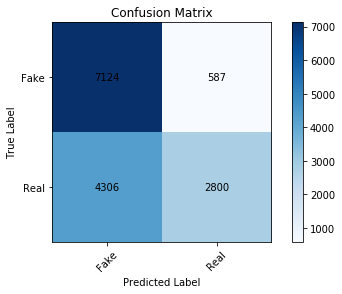

In [112]:
cnn_pred = model1.predict_classes(X_test_cnn)
cnn_res = confusion_matrix(y_test2, cnn_pred)
plot_confusion_matrix(cnn_res, ['Fake','Real'])


In [82]:
from sklearn.metrics import classification_report
y_pred = model1.predict_classes(X_test_cnn, batch_size=64, verbose=1)
print(classification_report(y_test2, y_pred))

14817/14817 [==============================] - 2s 104us/step
              precision    recall  f1-score   support

           0       0.62      0.92      0.74      7711
           1       0.83      0.39      0.53      7106

    accuracy                           0.67     14817
   macro avg       0.72      0.66      0.64     14817
weighted avg       0.72      0.67      0.64     14817

